# Train Plots Notebook

This notebook shows the convergance for different method through loss-plots.

First, some global imports:

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../modules')

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


next, we read the CSV containing all the train info:

In [16]:
df = pd.read_csv('out.csv')
df

,topo,nodes,lr,batch_size,mixing_steps,local_steps,loss
0,fc,100,0.01,20,1,1,0.106314
1,fc,100,0.01,20,1,1,0.104929
2,fc,100,0.01,20,1,1,0.103651
3,fc,100,0.01,20,1,1,0.102469
4,fc,100,0.01,20,1,1,0.101372
...,...,...,...,...,...,...,...
195,ring,100,0.01,20,1,1,0.062223
196,ring,100,0.01,20,1,1,0.061967
197,ring,100,0.01,20,1,1,0.061712
198,ring,100,0.01,20,1,1,0.061460


Now we can plot the train losses for the different topologies,

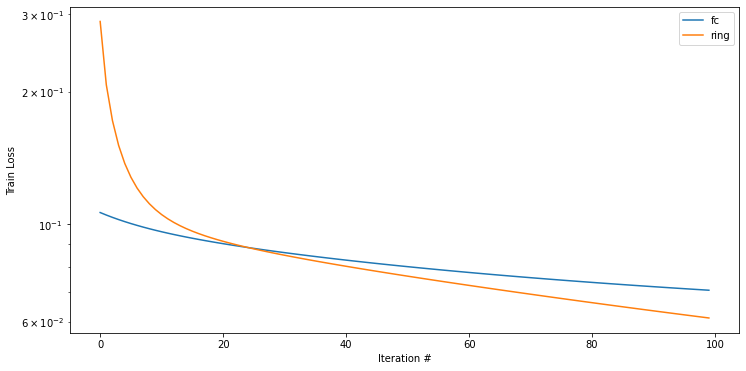

In [18]:
# plot options
figsize = (12, 6)

fig, axes = plt.subplots(1, 1, figsize=figsize)
ax = axes
ax.set_yscale('log')
for topo, data in df.groupby('topo'):
    ax.plot(range(len(data['loss'])), data['loss'], label=topo)
ax.legend()
ax.set_xlabel('Iteration #')
ax.set_ylabel('Train Loss')
plt.show()